<a href="https://www.kaggle.com/code/thomasfreire/lightning-for-lstm?scriptVersionId=142032790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Introduction:
The aim of this project is to display how to implement the Lightning modules to build a LSTM model. 
The data consists of the readings of sensors of turbofans that were operating until failure. The file in the dataset explains how the columns are displayed and how to understand the data. 
The task of the project is to predict the Remaining Useful Life of the turbofan after some cycles, the training dataset contains the cycles of over 709 turbofans (units) until the RUL approaches zero. 
However the units in the test dataset stops the counting of remaining cycles before zero in a random distribution. It might be this way for the model to really predict based in the 

### Cleaning the data:

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.8 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

In [3]:
import numpy as np
import pandas as pd
from itertools import chain
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch.optim as optim
from torch.utils.data import Dataset
from collections import defaultdict

import random

In [4]:
df1 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD001.txt', sep = ' ', header = None).drop(columns=[26,27])
df2 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD002.txt', sep = ' ', header = None).drop(columns=[26,27])
df3 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt', sep = ' ', header = None).drop(columns=[26,27])
df4 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD004.txt', sep = ' ', header = None).drop(columns=[26,27])

In [5]:
settings = ['setting_1','setting_2','setting_3']
sensors = ['sensor{}'.format(i+1) for i in range(0,21)]
indexes = ['unit_number','time_cycle']
columns = indexes + settings + sensors

In [6]:
df1.columns = columns
df2.columns = columns
df3.columns = columns
df4.columns = columns

In [7]:
def add_RUL_column(df):
    max_time_cycles = df.groupby(by='unit_number')['time_cycle'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycle']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [8]:
df1 = add_RUL_column(df1)
df2 = add_RUL_column(df2)
df3 = add_RUL_column(df3)
df4 = add_RUL_column(df4)

In [9]:
test1 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD001.txt', header = None, sep = ' ').drop(columns=[26,27])
test2 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD002.txt', header = None, sep = ' ').drop(columns=[26,27])
test3 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt', header = None, sep = ' ').drop(columns=[26,27])
test4 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD004.txt', header = None, sep = ' ').drop(columns=[26,27])

In [10]:
test1.columns = columns
test2.columns = columns
test3.columns = columns
test4.columns = columns

In [11]:
u1=test1['unit_number'].nunique()
u2=test2['unit_number'].nunique()
u3=test3['unit_number'].nunique()
u4=test4['unit_number'].nunique()

In [12]:
i1 =np.arange(1,u1+1).reshape(-1,1)
i2 =np.arange(1,u2+1).reshape(-1,1)
i3 =np.arange(1,u3+1).reshape(-1,1)
i4 =np.arange(1,u4+1).reshape(-1,1)

In [13]:
r1 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD001.txt', index_col=False,header= None)[0]).reshape(-1,1)
m1 = np.column_stack((i1, r1))
d1 = pd.DataFrame(m1, columns=['idx','rul1'])
rultest1 = d1.groupby('idx')['rul1'].max()

r2 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt', index_col=False,header= None)[0]).reshape(-1,1)
m2 = np.column_stack((i2, r2))
d2 = pd.DataFrame(m2, columns=['idx','rul2'])
rultest2 = d2.groupby('idx')['rul2'].max()

r3 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD003.txt', index_col=False,header= None)[0]).reshape(-1,1)
m3 = np.column_stack((i3, r3))
d3 = pd.DataFrame(m3, columns=['idx','rul3'])
rultest3 = d3.groupby('idx')['rul3'].max()

r4 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD004.txt', index_col=False,header= None)[0]).reshape(-1,1)
m4 = np.column_stack((i4, r4))
d4 = pd.DataFrame(m4, columns=['idx','rul4'])
rultest4 = d4.groupby('idx')['rul4'].max()

In [14]:
def add_RUL_column_test(test,rul):
    test_grouped_by_unit = test.groupby(by='unit_number')
    max_time_cycles = test_grouped_by_unit['time_cycle'].max()
    merged = test.merge(rul.to_frame(name='rul'), left_on='unit_number',right_index=True)
    merged = merged.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] =  (merged['rul']+merged['max_time_cycle'])-merged['time_cycle']
    return merged

In [15]:
df_test1 = add_RUL_column_test(test1,rultest1).drop(['rul','max_time_cycle'],axis=1)
df_test2 = add_RUL_column_test(test2,rultest2).drop(['rul','max_time_cycle'],axis=1)
df_test3 = add_RUL_column_test(test3,rultest3).drop(['rul','max_time_cycle'],axis=1)
df_test4 = add_RUL_column_test(test4,rultest4).drop(['rul','max_time_cycle'],axis=1)

In [16]:
df_train = pd.concat([df1,df2,df3,df4],ignore_index=True)
df_test = pd.concat([df_test1,df_test2,df_test3,df_test4],ignore_index=True)

In [17]:
ustrain1 = df1['unit_number'].max()
ustrain2 = df2['unit_number'].max()
ustrain3 = df3['unit_number'].max()
unit_abs_train = pd.concat([df1['unit_number'],
           df2['unit_number']+ustrain1,
           df3['unit_number']+ustrain1+ustrain2,
           df4['unit_number']+ustrain1+ustrain2+ustrain3
           ],
          ignore_index=True)

In [18]:
unit_abs_train= pd.Series(unit_abs_train, name= 'unit_abs')
unit_abs_train = pd.DataFrame(unit_abs_train, columns = ['unit_abs'])

In [19]:
ustest1 = df_test1['unit_number'].max()
ustest2 = df_test2['unit_number'].max()
ustest3 = df_test3['unit_number'].max()
unit_abs_test = pd.concat([df_test1['unit_number'],
           df_test2['unit_number']+ustest1,
           df_test3['unit_number']+ustest1+ustest2,
           df_test4['unit_number']+ustest1+ustest2+ustest3
           ],
          ignore_index=True)

In [20]:
unit_abs_test= pd.Series(unit_abs_test, name= 'unit_abs')
unit_abs_test = pd.DataFrame(unit_abs_test, columns = ['unit_abs'])

In [21]:
df_train = pd.concat([unit_abs_train,df_train], axis = 1)
df_test = pd.concat([unit_abs_test,df_test], axis = 1)

In [22]:
print('Number of unique units (turbofans) in the datasets: training data:', df_train['unit_abs'].nunique(), 'test data:', df_test['unit_abs'].nunique())

Number of unique units (turbofans) in the datasets: training data: 709 test data: 707


### Create a combination of the feature with PCA:

In [23]:
from sklearn.decomposition import PCA
x = df_train.iloc[:,2:-1]
#pca applied only on the timestamp, setting and sensor columns, not in the RUL column
pca = PCA()
pca.fit(x)
pca_data = pca.transform(x)

In [24]:
var = pca.explained_variance_ratio_
var[0]

0.904873954964741

In [25]:
cumsum= np.cumsum(var)

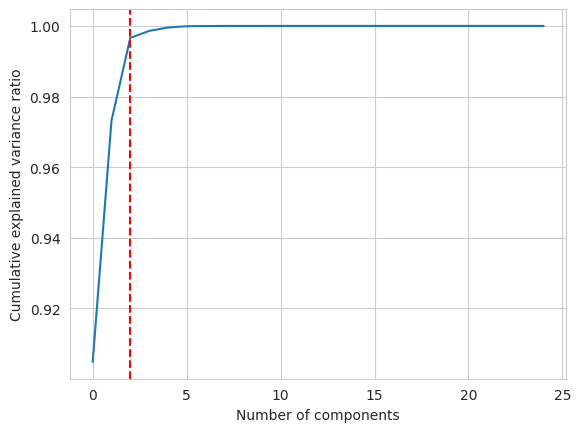

In [26]:
sns.set_style("whitegrid")
plt.plot(cumsum)
plt.axvline(x=2, color='red', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

In [27]:
pca_train = pca_data[:,:5]

In [28]:
x2 = df_test.iloc[:,2:-1]
pca = PCA()
pca.fit(x2)
pca_data2 = pca.transform(x2)
pca_test = pca_data2[:,:5]

### Smoothing:
Now let's smooth the data because the as it is stated in the document of the dataset, the readings of the sensors contain noise that might downgrade the LSTM perfomance.

In [29]:
df_train.columns

Index(['unit_abs', 'unit_number', 'time_cycle', 'setting_1', 'setting_2',
       'setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11',
       'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17',
       'sensor18', 'sensor19', 'sensor20', 'sensor21', 'RUL'],
      dtype='object')

In [30]:
#Smoothing Train DF
df_train_for_smo = df_train[['unit_abs','setting_1', 'setting_2','setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                             'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11','sensor12', 'sensor13', 'sensor14',
                             'sensor15', 'sensor16', 'sensor17','sensor18', 'sensor19', 'sensor20', 'sensor21']]
alpha = .2
train_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_train_for_smo[df_train_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    train_smooth = pd.concat([train_smooth, smoothed_df])

In [31]:
# Smoothing Test DF
df_test_for_smo = df_test[['unit_abs','setting_1', 'setting_2','setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                             'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11','sensor12', 'sensor13', 'sensor14',
                             'sensor15', 'sensor16', 'sensor17','sensor18', 'sensor19', 'sensor20', 'sensor21']]
test_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_test_for_smo[df_test_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    test_smooth = pd.concat([test_smooth, smoothed_df])

In [32]:
# Getting back the column time cycle and RUl to be standardize:
train = pd.concat([train_smooth,df_train[['time_cycle','RUL']]],axis=1)
test = pd.concat([test_smooth,df_test[['time_cycle','RUL']]],axis=1)

In [33]:
train.columns

Index(['unit_abs', 'setting_1', 'setting_2', 'setting_3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'time_cycle', 'RUL'],
      dtype='object')

In [34]:
scaler = MinMaxScaler(feature_range=(-1, 1))
columns_scaled = ['setting_1', 'setting_2', 'setting_3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'time_cycle', 'RUL']

In [35]:
scaled_train_array = scaler.fit_transform(train.drop(['unit_abs'],axis=1))
scaled_test_array = scaler.fit_transform(test.drop(['unit_abs'],axis=1))
df_train_sc = pd.DataFrame(scaled_train_array,columns = columns_scaled)
df_test_sc = pd.DataFrame(scaled_test_array,columns = columns_scaled)

In [36]:
#getting back the unit ID (unit_abs) for the dataframes:
train = pd.concat([df_train['unit_abs'], df_train_sc],axis=1)
test = pd.concat([df_test['unit_abs'], df_test_sc],axis=1)

In [37]:
train

,unit_abs,setting_1,setting_2,setting_3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,time_cycle,RUL
0,1,-0.999705,-0.999525,1.000000,1.000000,0.960514,0.903841,0.841866,1.000000,1.000000,...,0.344143,-0.853202,1.000000,0.887073,1.000000,1.000000,0.958781,0.955216,-1.000000,-0.295203
1,1,-0.999680,-0.999478,1.000000,1.000000,0.961737,0.906201,0.844403,1.000000,1.000000,...,0.337275,-0.851390,1.000000,0.887073,1.000000,1.000000,0.957960,0.955321,-0.996310,-0.298893
2,1,-0.999719,-0.999155,1.000000,1.000000,0.963455,0.903825,0.847492,1.000000,1.000000,...,0.333456,-0.852003,1.000000,0.878592,1.000000,1.000000,0.956620,0.953601,-0.992620,-0.302583
3,1,-0.999703,-0.999039,1.000000,1.000000,0.964830,0.896136,0.847636,1.000000,1.000000,...,0.330979,-0.859798,1.000000,0.880289,1.000000,1.000000,0.954591,0.952900,-0.988930,-0.306273
4,1,-0.999715,-0.999041,1.000000,1.000000,0.966003,0.890051,0.852096,1.000000,1.000000,...,0.328969,-0.857020,1.000000,0.885886,1.000000,1.000000,0.953241,0.953031,-0.985240,-0.309963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,709,0.305665,0.483632,0.662201,-0.419789,-0.355605,-0.119324,-0.208639,-0.416198,-0.449868,...,0.171301,-0.281545,-0.231439,-0.125686,0.232363,0.662201,-0.451357,-0.448046,-0.077491,-0.985240
160355,709,0.044625,0.187902,0.729761,-0.135831,-0.086456,0.095573,0.027607,-0.132959,-0.160900,...,0.251002,-0.424948,0.014849,0.093828,0.385891,0.729761,-0.164954,-0.160669,-0.073801,-0.988930
160356,709,-0.164207,-0.049393,0.783809,0.091335,0.129826,0.277287,0.220390,0.093633,0.070275,...,0.322922,-0.535193,0.211879,0.265199,0.508713,0.783809,0.069638,0.071775,-0.070111,-0.992620
160357,709,0.001959,0.159536,0.827047,-0.102824,-0.022703,0.170584,0.092509,-0.066457,-0.086745,...,0.314662,-0.505719,-0.030497,0.156340,0.467435,0.827047,-0.077971,-0.077272,-0.066421,-0.996310


### LightLGBM Model:
Before we start to train our model in the pytorch-lightning LSTM model, I would like to have a traditional ML model for comparisson. I choose LightLGBM because it performs well in sequence data:

In [38]:
from lightgbm import LGBMRegressor
X_train = df_train.drop(['unit_abs','unit_number','RUL'],axis=1) 
y_train = train[['RUL']]

X_test = df_test.drop(['unit_abs','unit_number','RUL'],axis=1) 
y_test = test[['RUL']]

I used the RUL scaled because I want the MSE to be in the same scale of the pytorch-lightning. 

In [39]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [40]:
lgbm_pred = lgbm.predict(X_test)

In [41]:
print('The MSE of the LightGBM model is ', mean_squared_error(y_test[['RUL']],lgbm_pred))

The MSE of the LightGBM model is  0.04357012977704913


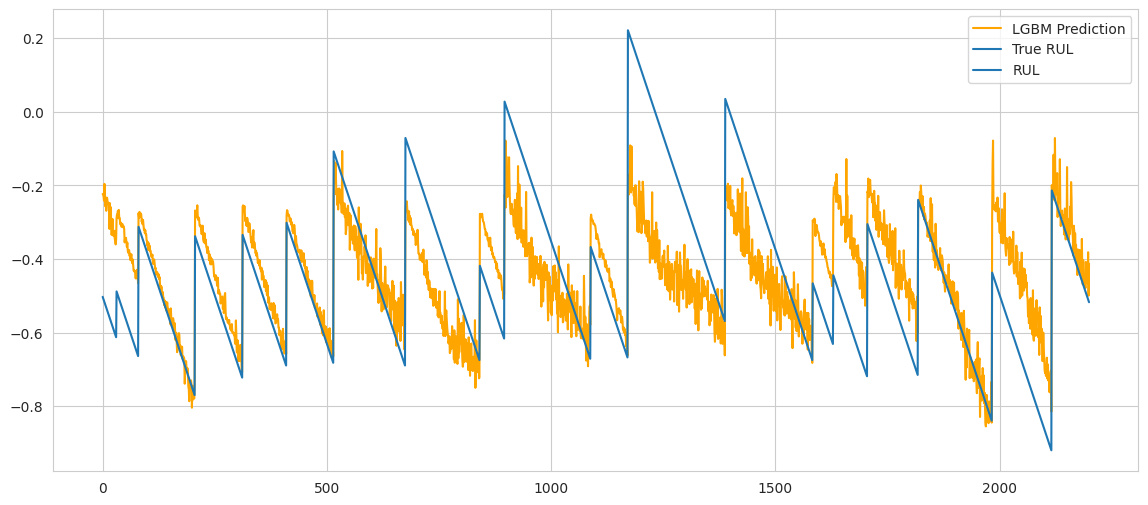

In [42]:
plt.figure(figsize=(14,6),)
sns.lineplot(lgbm_pred[:2200],color='orange', label='LGBM Prediction')
sns.lineplot(y_test[['RUL']][:2200],color='green', label='True RUL')
plt.show()

### Preprocess for Neural Network:

Plotting the features to see how they evolve of the cycles for selecting the best features and discard unecessary columns:

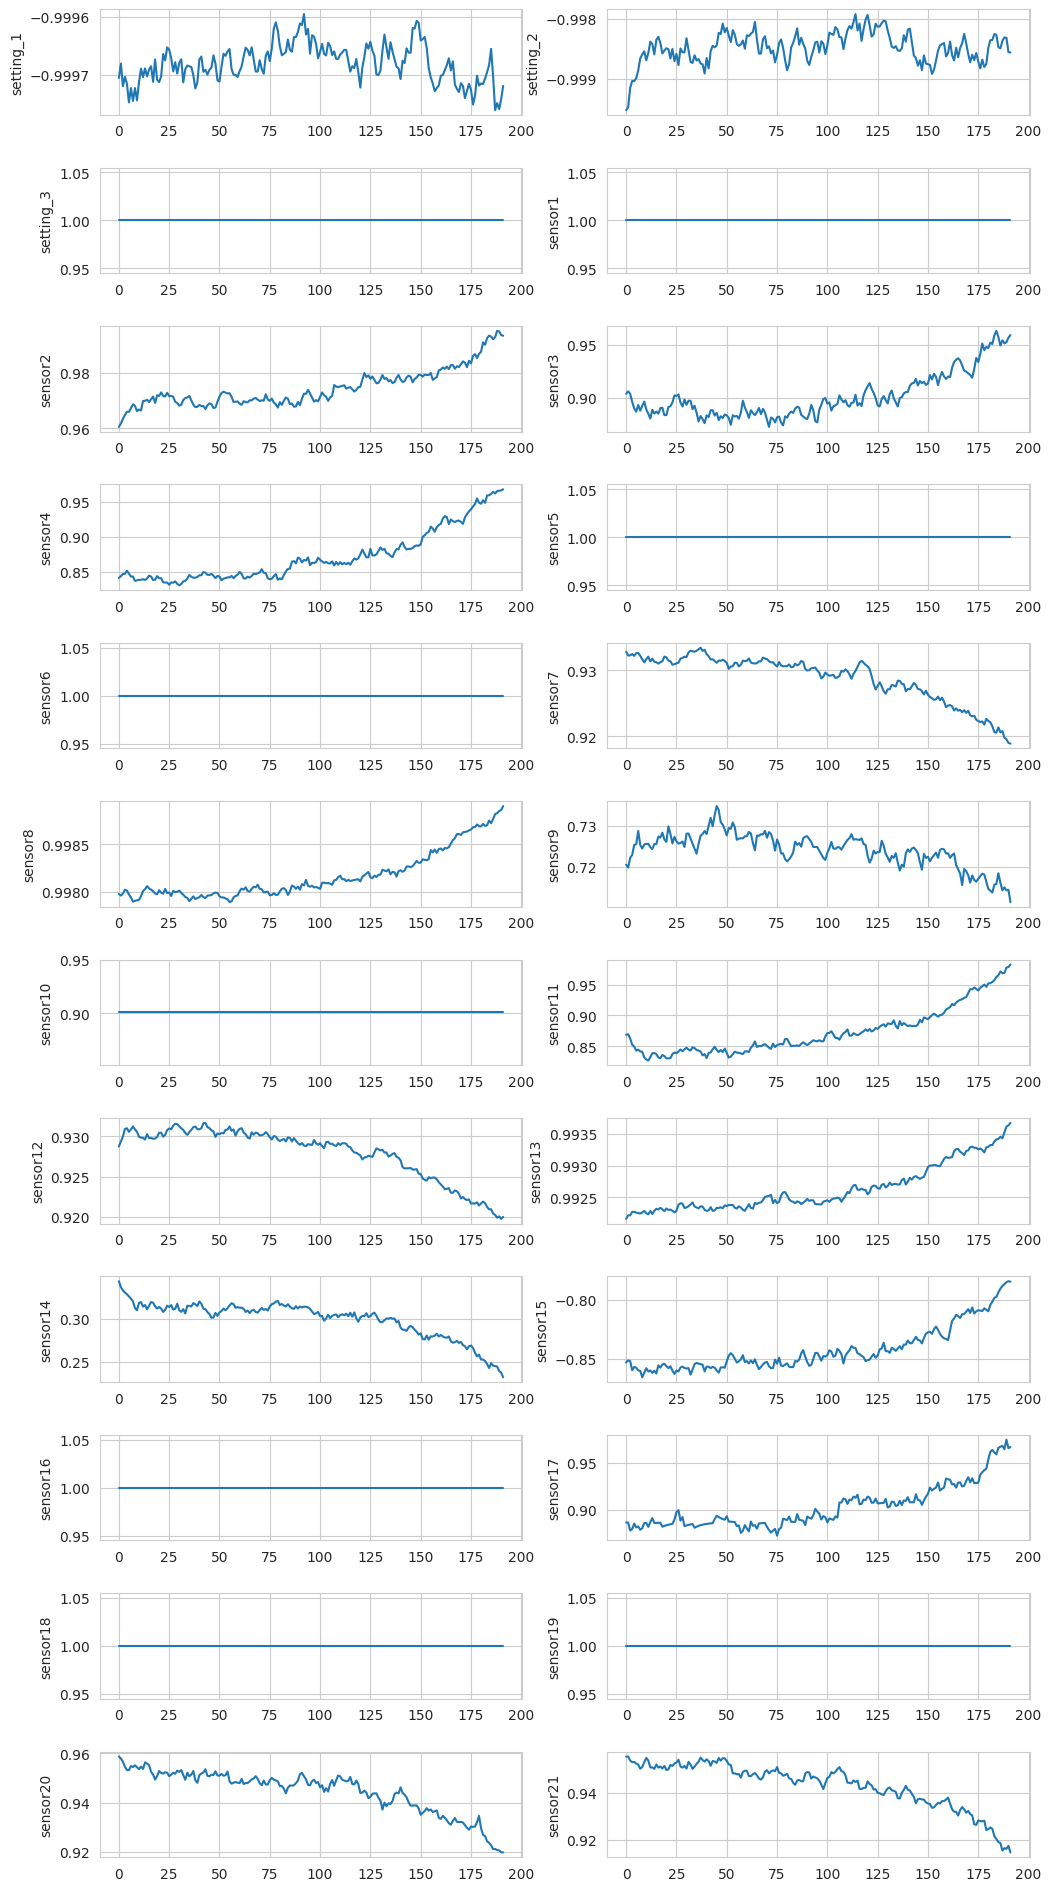

In [43]:
fig, axes = plt.subplots(12, 2, figsize=(12, 24))
plt.subplots_adjust(hspace=0.5)

for i in range(1,25):
    row = (i - 1) // 2
    col = (i - 1) % 2
    sns.lineplot(train[train['unit_abs']==1].iloc[:5000,i], ax=axes[row, col])
plt.show()

In [44]:
# The correlation of the features with the remaining useful time for one unit:
cor = train[train['unit_abs']==1].corr()
corl = cor['RUL'].abs().sort_values(ascending=False)
corl

RUL           1.000000
time_cycle    1.000000
sensor13      0.912513
sensor21      0.902345
sensor20      0.899505
sensor7       0.897847
sensor4       0.896811
sensor11      0.894934
sensor12      0.886816
sensor2       0.874611
sensor8       0.874170
sensor17      0.864135
sensor15      0.862653
sensor14      0.859321
sensor3       0.776728
sensor9       0.714364
setting_2     0.194682
setting_1     0.040514
unit_abs           NaN
setting_3          NaN
sensor1            NaN
sensor5            NaN
sensor6            NaN
sensor10           NaN
sensor16           NaN
sensor18           NaN
sensor19           NaN
Name: RUL, dtype: float64

In [45]:
# Utilizing the top 10 sensor reading correlated features:
train_selected = train[['unit_abs','time_cycle','sensor13','sensor21','sensor20','sensor7','sensor4',
                        'sensor11','sensor12','sensor2','sensor8','sensor17','RUL']]

test_selected = test[['unit_abs','time_cycle','sensor13','sensor21','sensor20','sensor7','sensor4',
                        'sensor11','sensor12','sensor2','sensor8','sensor17','RUL']]

In [46]:
#Extract the validation set and predicting sets from the trainning df and test df:
itrain = train_selected[train_selected['unit_abs']<610]
ival = train_selected[train_selected['unit_abs']>609].reset_index(drop=True)
itest = test_selected
ipred  = test_selected[test_selected['unit_abs']>607].reset_index(drop=True)

In [47]:
print('Units for each set:',
      'Train:' ,itrain['unit_abs'].nunique(), 
      ', Validation:', ival['unit_abs'].nunique(), 
      ', Test:', itest['unit_abs'].nunique(),
      ', Prediction:', ipred['unit_abs'].nunique()
     )

Units for each set: Train: 609 , Validation: 100 , Test: 707 , Prediction: 100


In [48]:
# Create sequences for the dataset:
def create_sequences(data: pd.DataFrame,target,seq_len):
    sequences = []
    data_size = len(data)

    for i in tqdm(range(data_size-seq_len+1)):
        sequence = data.iloc[i:i+seq_len,:-1]
        label_position = (i+seq_len-1)
        label = data.iloc[label_position][target]

        sequences.append([sequence,label])
    return sequences

In [49]:
seq_len =10
train_sequences = np.array(create_sequences(itrain,'RUL',seq_len))
val_sequences = np.array(create_sequences(ival, 'RUL', seq_len ))
test_sequences = np.array(create_sequences(itest,'RUL',seq_len))
pred_sequences = np.array(create_sequences(ipred,'RUL',seq_len))

  0%|          | 0/135607 [00:00<?, ?it/s]

  0%|          | 0/24734 [00:00<?, ?it/s]

  0%|          | 0/104888 [00:00<?, ?it/s]

  0%|          | 0/15603 [00:00<?, ?it/s]

Now that we have the sequences for each dataset the model can be built:

### Let's get to the model building:

### Dataset:
First we have the Dataset model that defines how the model will iterate over each dataset to retrieve the sequences and its respective labels:

In [50]:
class TurbofanDataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]
        sequence = sequence.drop('unit_abs',axis=1)
        return dict(
          sequence=torch.Tensor(sequence.to_numpy()).float(),
          label = torch.tensor(label).float()
      )

### Lightning Data Module:
This module create for us the batches and loads the datasets for its usage. We can set the size of the batches for each dataset:

In [51]:
class TurbofanDataModule(L.LightningDataModule):

    def __init__(self, train_sequences,val_sequences,test_sequences,pred_sequences,batch_size=128):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.pred_sequences = pred_sequences
        self.batch_size = batch_size
        
        seed = 42
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def setup(self, stage=None):
        self.train_dataset = TurbofanDataset(self.train_sequences)
        self.val_dataset = TurbofanDataset(self.val_sequences)
        self.test_dataset = TurbofanDataset(self.test_sequences)
        self.pred_dataset = TurbofanDataset(self.pred_sequences)

    def train_dataloader(self):
        return DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle= True,
            num_workers=1
        )
    
    def val_dataloader(self):
        return DataLoader(
            dataset = self.val_dataset,
            batch_size= len(self.val_sequences)//4,
            shuffle = True,
            num_workers=1
        )

    def test_dataloader(self):
        return DataLoader(
            dataset = self.test_dataset,
            batch_size= len(self.test_sequences)//4,
            shuffle = False,
            num_workers=1
        )
    
    def predict_dataloader(self):
        return DataLoader(
            dataset = self.pred_dataset,
            batch_size= len(self.pred_sequences)//4,
            shuffle = False,
            num_workers=1
        )

### Neural Network Module:
Here we can build the architecture of the NN model, the core of the model.

In [52]:
class RULPredModel(nn.Module):

    def __init__(self, n_features=11, n_hidden=160,n_layers=1,dropout = 0.3):
        super(RULPredModel, self).__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = dropout
            
        )
        
        self.other_layers = nn.Sequential(
            nn.Linear(in_features=self.n_hidden, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=1),
        )
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]
        out = self.other_layers(lstm_out)

        return out

### Lightning Module:
The lightning Module is a wrapping implementation that prepare our model for training in a structured manner. We can set how the model will iterate over the datasets, the criterion of validation, the learning rate and so on.

In [53]:
class RULLightning(L.LightningModule):

    def __init__(self, model=RULPredModel(), lr=0.004):
        super(RULLightning,self).__init__()
        self.lr = lr
        self.model = model
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, 
                              labels.unsqueeze(dim=1)
                              )
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, 
                              labels.unsqueeze(dim=1)
                             )
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs,
                              labels.unsqueeze(dim=1)
                             )
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, 
                     batch, 
                     batch_idx, 
                    ):
        sequences = batch['sequence']
        y_hat = self(sequences)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

### Logger and Callback:
With the logger we set the directory where we can control the version of the model.
The callback manage the checkpoint and the monitor to define how to validate our model, we choose the validation loss for each epoach.
With the early stopping we can define if a model is not improving over a N number of epoachs and if it the patience is reached the model stops to train.

In [54]:
logger_v1 = TensorBoardLogger(save_dir="/kaggle/working/", name="logs_v1")
callback_v1 = [ModelCheckpoint(save_top_k=1,
                             verbose=True,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger_v1.log_dir
                              ),
               EarlyStopping(monitor='val_loss',
                             patience=3,
                             mode='min',
                            )
              ]

In [55]:
# Instatiating the Data Module:
dm_v1 = TurbofanDataModule(train_sequences,
                        val_sequences,
                        test_sequences,
                        pred_sequences
                        )

In [56]:
# Instatiating the NN Module with the default parameters:
RULPred1 = RULPredModel()

In [57]:
# Instatiating the Lightning Module passin the NN Module
model_v1 = RULLightning(RULPred1)

In [58]:
trainer_v1 = L.Trainer(max_epochs=20,
                    callbacks = callback_v1,
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger_v1,
                     )
trainer_v1.fit(model_v1, datamodule= dm_v1)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 112 K 
1 | criterion | MSELoss      | 0     
-------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.451     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 1060: 'val_loss' reached 0.04748 (best 0.04748), saving model to '/kaggle/working/logs_v1/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 2120: 'val_loss' reached 0.04567 (best 0.04567), saving model to '/kaggle/working/logs_v1/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 3180: 'val_loss' reached 0.04487 (best 0.04487), saving model to '/kaggle/working/logs_v1/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 4240: 'val_loss' reached 0.04243 (best 0.04243), saving model to '/kaggle/working/logs_v1/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 5300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 6360: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 6, global step 7420: 'val_loss' was not in top 1


In [59]:
cp_v1 = "/kaggle/working/logs_v1/version_0/best_model.ckpt"

In [60]:
test_v1 = trainer_v1.test(datamodule=dm_v1, ckpt_path=cp_v1)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v1/version_0/best_model.ckpt
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v1/version_0/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05260641500353813    │
└───────────────────────────┴───────────────────────────┘

### Worse than LightGBM (0.04357)

In [61]:
predicted_v1 = trainer_v1.predict(datamodule=dm_v1, ckpt_path=cp_v1)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v1/version_0/best_model.ckpt
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v1/version_0/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [62]:
def get_pred(df:list):
    pred_np = df[0].numpy().reshape(1,-1).reshape(-1)
    for i in range(1,5):
        values = df[i].numpy().reshape(1,-1).reshape(-1)
        pred_np = np.append(pred_np,values)
    pred_series = pd.Series(pred_np, name='RUL')
    return pred_series

In [63]:
pred_v1 = get_pred(predicted_v1)

In [64]:
true_y = pd.Series(pred_sequences[:,1])
df_true_y = pd.concat([ipred[9:]['unit_abs'].reset_index(drop=True),true_y.rename('RUL')],axis=1)

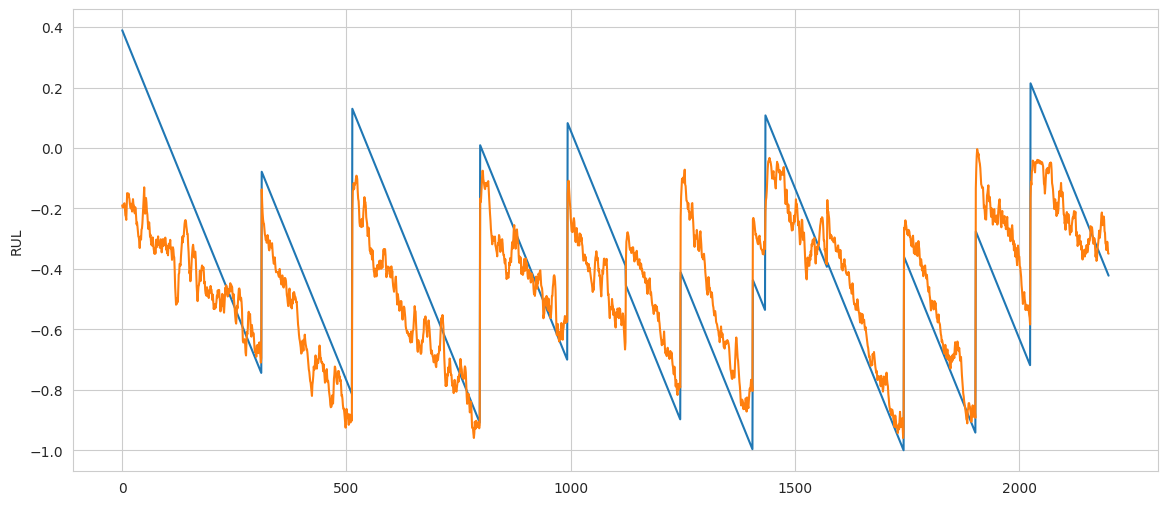

In [65]:
plt.figure(figsize=(14,6))
sns.lineplot(true_y[:2200])
sns.lineplot(pred_v1[:2200])
plt.show()

### Change the structure of the LSTM for comparison:

In [66]:
logger_v2 = TensorBoardLogger(save_dir="/kaggle/working/", name="logs_v2")
callback_v2 = [ModelCheckpoint(save_top_k=1,
                             verbose=True,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger_v2.log_dir
                              ),
               EarlyStopping(monitor='val_loss',
                             patience=3,
                             mode='min',
                            )
              ]

### Setting the hidden units to 200, and increasing the number of layers from 1 to 3, also increasing the dropout to avoid overfitting:

In [67]:
rulpred2 = RULPredModel(n_features=11,n_hidden=200,n_layers=3,dropout=0.65)

In [68]:
model_v2 = RULLightning(rulpred2)

In [69]:
trainer_v2 = L.Trainer(max_epochs=20,
                    callbacks = callback_v2,
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger_v2,
                     )
trainer_v2.fit(model_v2, datamodule= dm_v1)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 816 K 
1 | criterion | MSELoss      | 0     
-------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 1060: 'val_loss' reached 0.11790 (best 0.11790), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 2120: 'val_loss' reached 0.07314 (best 0.07314), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 3180: 'val_loss' reached 0.04918 (best 0.04918), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 4240: 'val_loss' reached 0.04813 (best 0.04813), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 5300: 'val_loss' reached 0.04526 (best 0.04526), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 6360: 'val_loss' reached 0.04369 (best 0.04369), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 6, global step 7420: 'val_loss' reached 0.04331 (best 0.04331), saving model to '/kaggle/working/logs_v2/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 7, global step 8480: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 8, global step 9540: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 9, global step 10600: 'val_loss' was not in top 1


In [70]:
cp_v2 = "/kaggle/working/logs_v2/version_0/best_model.ckpt"

In [71]:
test_v2 = trainer_v2.test(datamodule=dm_v1, ckpt_path=cp_v2)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v2/version_0/best_model.ckpt
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v2/version_0/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05892946943640709    │
└───────────────────────────┴───────────────────────────┘

In [72]:
predicted_v2 = trainer_v2.predict(datamodule=dm_v1, ckpt_path=cp_v2)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v2/version_0/best_model.ckpt
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v2/version_0/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [73]:
pred_v2 = get_pred(predicted_v2)

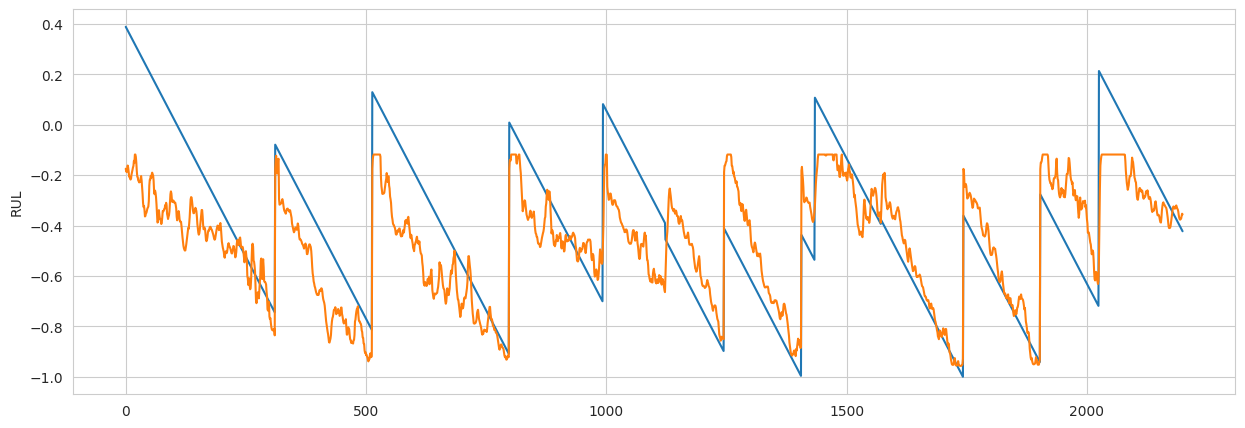

In [74]:
plt.figure(figsize=(15,5))
sns.lineplot(true_y[:2200])
sns.lineplot(pred_v2[:2200])
plt.show()

It seemed by the plot that the increase in layers smoothed the predictions. However, the change in the structure the LSTM could not outstand the performance of the LightGBM when it comes to predict over the test-set.
The model has for sure room for improvements but the goal of this project is to apply lightning in a Neural Network model and to display how it can help to organize our model.